# Reconhecendo Caracteres das Placas

## Import das bibliotecas e funções

In [1]:
import sys
sys.version

'3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [2]:
import cv2

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(12321)

import pandas as pd

import os, json, itertools, math, time

In [3]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.python.keras.utils import to_categorical

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, f1_score

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # Função importada dos exemplos do SKLearn
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(30,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
def plot(imagem):
    plt.figure(figsize=(30,12))
    plt.imshow(imagem, cmap="gray")
    plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

## Import dos dados

In [6]:
path = "../data/training/"

In [7]:
def get_tboard(nmap):
    l = ["reconhece-digitos-{}", "reconhece-caracteres-{}", "reconhece-digitos-caracteres-",
         "reconhece-digitos-mnist-{}"]
    name = l[nmap].format(time.time())
    tbpath = '/Users/juliobguedes/Documents/ufcg/current/ia/logs/{}'.format(name)
    return TensorBoard(log_dir=tbpath)

In [8]:
digitos = []
label_digitos = []
caracteres = []
label_caracteres=[]

# Considera apenas imagens corretas
# Arquivos ._ não são imagens válidas, embora terminem com .png
files = [f for f in os.listdir(path) if f.endswith(".png") and f.startswith("track")]

for arq in files:
        
    img = cv2.imread(path + arq, 0)
    w, c, d = arq.split("-")
    if (d[0] == "1"):
        digitos.append(img)
        label_digitos.append(int(chr(int(c))))
        
    elif (d[0] == "0"):
        caracteres.append(img)
        label_caracteres.append(chr(int(c)))

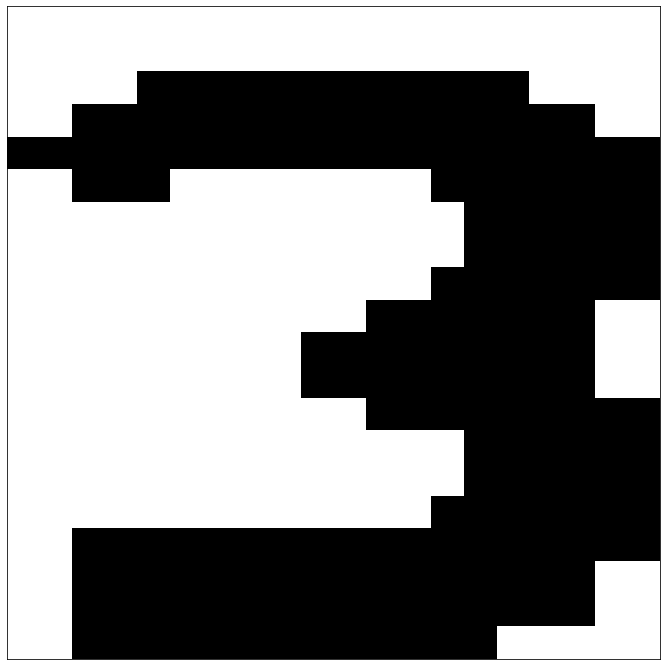

In [9]:
plot(digitos[0])

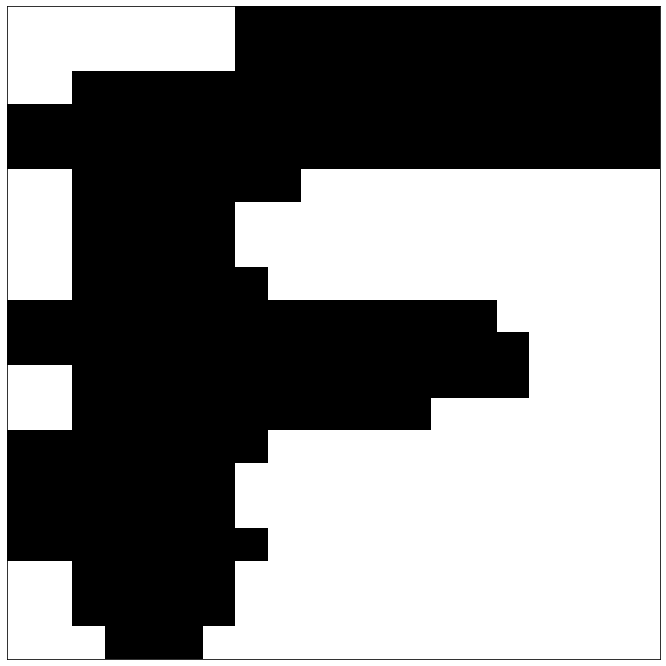

In [10]:
plot(caracteres[0])

In [11]:
valpath = "../data/validation/"
valdigitos = []
vallabel_digitos = []
valcaracteres = []
vallabel_caracteres=[]

# Considera apenas imagens corretas
# Arquivos ._ não são imagens válidas, embora terminem com .png
files = [f for f in os.listdir(valpath) if f.endswith(".png") and f.startswith("track")]

for arq in files:
        
    img = cv2.imread(valpath + arq, 0)
    w, c, d = arq.split("-")
    if (d[0] == "1"):
        valdigitos.append(img)
        vallabel_digitos.append(int(chr(int(c))))
        
    elif (d[0] == "0"):
        valcaracteres.append(img)
        vallabel_caracteres.append(chr(int(c)))

## Preparação dos dados para treino

In [12]:
prop_validacao_digitos = len(valdigitos) / (len(valdigitos) + len(digitos))

digitos.extend(valdigitos)
label_digitos.extend(vallabel_digitos)

prop_validacao_caracteres = len(valcaracteres) / (len(valcaracteres) + len(caracteres))

caracteres.extend(valcaracteres)
label_caracteres.extend(vallabel_caracteres)

PS: Como a função `to_categorical` de Keras não consegue converter letras para variáveis categóricas, optei por usar o padrão onde A = 0, B = 1, C = 3, e assim por diante. Dessa forma, cada letra será convertida em seu valor ASCII subtraido de 65 (valor de A).

In [13]:
digitos = np.array([np.expand_dims(d, axis=2) for d in digitos])
digitos_categoricos = to_categorical(label_digitos, num_classes=10)

In [14]:
caracteres = np.array([np.expand_dims(c, axis=2) for c in caracteres])
caracteres_ord = [ord(c) - 65 for c in label_caracteres]
caracteres_categoricos = to_categorical(caracteres_ord, num_classes=26)

In [15]:
caracteres_categoricos[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [16]:
valdigitos, valcaracteres, vallabel_digitos, vallabel_caracteres = None, None, None, None

## CNN - Digitos

Propõe-se então a seguinte estrutura para a rede neural:

* Uma camada convolucional com 64 neurõnios
* Uma camada de pooling 2x2
* Transformação de dados bidimensionais para unidimensionais
* Uma camada totalmente conectada, que possui 4 camadas escondidas:
    * Uma camada com 256 neurônios e ativação sigmoide
    * Uma camada com 512 neurônios e ativação relu
    * Uma camada com 256 neurônios e ativação relu
    * Uma camada com 512 neurônios e ativação relu
* Uma camada de saida, com ativação softmax

In [17]:
model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=(20, 20, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())

model.add(Dense(256, activation="sigmoid"))
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer="adam",
              metrics=["categorical_accuracy"],
              loss="categorical_crossentropy")

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
model.fit(digitos, digitos_categoricos, validation_split=prop_validacao_digitos, epochs=100, callbacks=[get_tboard(0)])

Train on 6330 samples, validate on 3180 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
6330/6330 [==============================] - 8s 1ms/sample - loss: 1.0191 - categorical_accuracy: 0.6499 - val_loss: 0.7435 - val_categorical_accuracy: 0.7289
Epoch 2/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.5226 - categorical_accuracy: 0.8114 - val_loss: 0.5359 - val_categorical_accuracy: 0.8258
Epoch 3/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.3207 - categorical_accuracy: 0.8885 - val_loss: 0.4063 - val_categorical_accuracy: 0.8877
Epoch 4/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.1895 - categorical_accuracy: 0.9349 - val_loss: 0.3198 - val_categorical_accuracy: 0.9072
Epoch 5/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.1916 - categorical_accuracy: 0.9362 - val_loss: 0.4627 - val_categorical_accuracy: 0.8667
Epoch 6/100
6330/6330 [==========================

Epoch 47/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0468 - categorical_accuracy: 0.9836 - val_loss: 0.4332 - val_categorical_accuracy: 0.9270
Epoch 48/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0459 - categorical_accuracy: 0.9833 - val_loss: 0.3139 - val_categorical_accuracy: 0.9314
Epoch 49/100
6330/6330 [==============================] - 8s 1ms/sample - loss: 0.0531 - categorical_accuracy: 0.9815 - val_loss: 0.4446 - val_categorical_accuracy: 0.9220
Epoch 50/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0599 - categorical_accuracy: 0.9796 - val_loss: 0.4291 - val_categorical_accuracy: 0.9211
Epoch 51/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0592 - categorical_accuracy: 0.9801 - val_loss: 0.3719 - val_categorical_accuracy: 0.9349
Epoch 52/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0633 - categorical_accuracy: 0.9765 - val_loss: 0.3775 - v

6330/6330 [==============================] - 8s 1ms/sample - loss: 0.0660 - categorical_accuracy: 0.9760 - val_loss: 0.4877 - val_categorical_accuracy: 0.8846
Epoch 95/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0918 - categorical_accuracy: 0.9698 - val_loss: 0.4787 - val_categorical_accuracy: 0.8871
Epoch 96/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0761 - categorical_accuracy: 0.9728 - val_loss: 0.4882 - val_categorical_accuracy: 0.8843
Epoch 97/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0784 - categorical_accuracy: 0.9735 - val_loss: 0.3893 - val_categorical_accuracy: 0.9277
Epoch 98/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0810 - categorical_accuracy: 0.9744 - val_loss: 0.4441 - val_categorical_accuracy: 0.9132
Epoch 99/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0686 - categorical_accuracy: 0.9755 - val_loss: 0.4246 - val_categorica

In [19]:
testpath = "../data/testing/"
testdigitos = []
testlabel_digitos = []
testcaracteres = []
testlabel_caracteres=[]

# Considera apenas imagens corretas
# Arquivos ._ não são imagens válidas, embora terminem com .png
files = [f for f in os.listdir(testpath) if f.endswith(".png") and f.startswith("track")]

for arq in files:
        
    img = cv2.imread(testpath + arq, 0)
    w, c, d = arq.split("-")
    if (d[0] == "1"):
        testdigitos.append(img)
        testlabel_digitos.append(int(chr(int(c))))
        
    elif (d[0] == "0"):
        testcaracteres.append(img)
        testlabel_caracteres.append(chr(int(c)))

In [20]:
testdigitos = np.array([np.expand_dims(d, axis=2) for d in testdigitos])

In [21]:
testcaracteres = np.array([np.expand_dims(c, axis=2) for c in testcaracteres])

In [22]:
pred = model.predict(testdigitos)
rpred = [np.argmax(i) for i in pred]

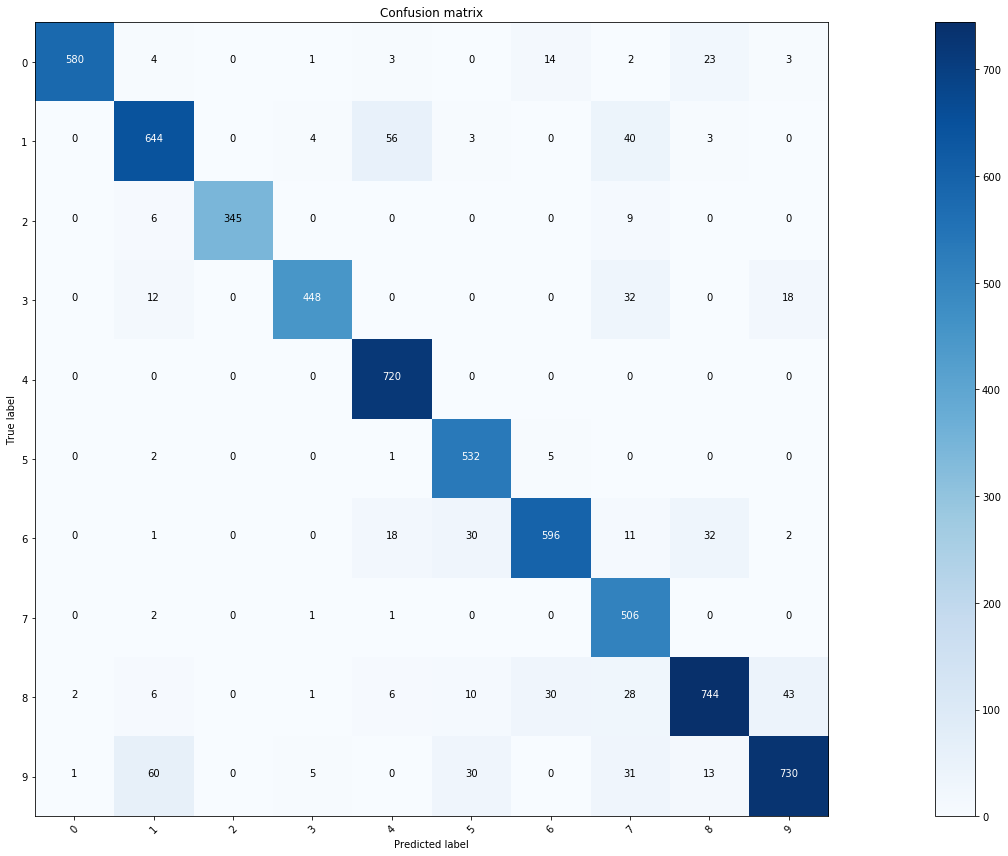

In [23]:
matriz = confusion_matrix(testlabel_digitos, rpred)
plot_confusion_matrix(matriz, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [24]:
accuracy_score(testlabel_digitos, rpred)

0.9062015503875969

## CNN - Caracteres

In [25]:
model2 = Sequential()
model2.add(Conv2D(64, (3,3), input_shape=(20, 20, 1)))
model2.add(MaxPooling2D((2,2)))
model2.add(Flatten())

model2.add(Dense(256, activation="sigmoid"))
model2.add(Dense(512, activation="relu"))
model2.add(Dense(256, activation="sigmoid"))
model2.add(Dense(512, activation="relu"))
model2.add(Dense(26, activation="softmax"))

model2.compile(optimizer="adam",
              metrics=["categorical_accuracy"],
              loss="categorical_crossentropy")

In [26]:
model2.fit(caracteres, caracteres_categoricos,
           validation_split=prop_validacao_caracteres, epochs=100,
           callbacks=[get_tboard(1)])

Train on 5130 samples, validate on 2550 samples
Epoch 1/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 2.1353 - categorical_accuracy: 0.4021 - val_loss: 1.5507 - val_categorical_accuracy: 0.6008
Epoch 2/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.9803 - categorical_accuracy: 0.6889 - val_loss: 1.4095 - val_categorical_accuracy: 0.6337
Epoch 3/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.6784 - categorical_accuracy: 0.7655 - val_loss: 1.1536 - val_categorical_accuracy: 0.7337
Epoch 4/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.5094 - categorical_accuracy: 0.8175 - val_loss: 1.2477 - val_categorical_accuracy: 0.7286
Epoch 5/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.4296 - categorical_accuracy: 0.8398 - val_loss: 1.4111 - val_categorical_accuracy: 0.7027
Epoch 6/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.2948 - categoric

5130/5130 [==============================] - 5s 1ms/sample - loss: 0.1247 - categorical_accuracy: 0.9538 - val_loss: 1.5950 - val_categorical_accuracy: 0.7761
Epoch 49/100
5130/5130 [==============================] - 5s 1ms/sample - loss: 0.0975 - categorical_accuracy: 0.9649 - val_loss: 1.6213 - val_categorical_accuracy: 0.7757
Epoch 50/100
5130/5130 [==============================] - 5s 1ms/sample - loss: 0.1152 - categorical_accuracy: 0.9571 - val_loss: 1.5445 - val_categorical_accuracy: 0.8000
Epoch 51/100
5130/5130 [==============================] - 5s 1ms/sample - loss: 0.0971 - categorical_accuracy: 0.9616 - val_loss: 1.6013 - val_categorical_accuracy: 0.8063
Epoch 52/100
5130/5130 [==============================] - 5s 1ms/sample - loss: 0.0775 - categorical_accuracy: 0.9700 - val_loss: 1.5467 - val_categorical_accuracy: 0.8051
Epoch 53/100
5130/5130 [==============================] - 5s 1ms/sample - loss: 0.0892 - categorical_accuracy: 0.9673 - val_loss: 1.5956 - val_categorica

Epoch 96/100
5130/5130 [==============================] - 5s 1ms/sample - loss: 0.1410 - categorical_accuracy: 0.9478 - val_loss: 1.6913 - val_categorical_accuracy: 0.7576
Epoch 97/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.1347 - categorical_accuracy: 0.9462 - val_loss: 1.9622 - val_categorical_accuracy: 0.7580
Epoch 98/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.1411 - categorical_accuracy: 0.9421 - val_loss: 1.9242 - val_categorical_accuracy: 0.7573
Epoch 99/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.1305 - categorical_accuracy: 0.9468 - val_loss: 2.0009 - val_categorical_accuracy: 0.7596
Epoch 100/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.1137 - categorical_accuracy: 0.9569 - val_loss: 1.9549 - val_categorical_accuracy: 0.7580


In [27]:
pred_c = model2.predict(testcaracteres)
rpred_c = [chr(np.argmax(i) + 65) for i in pred_c]

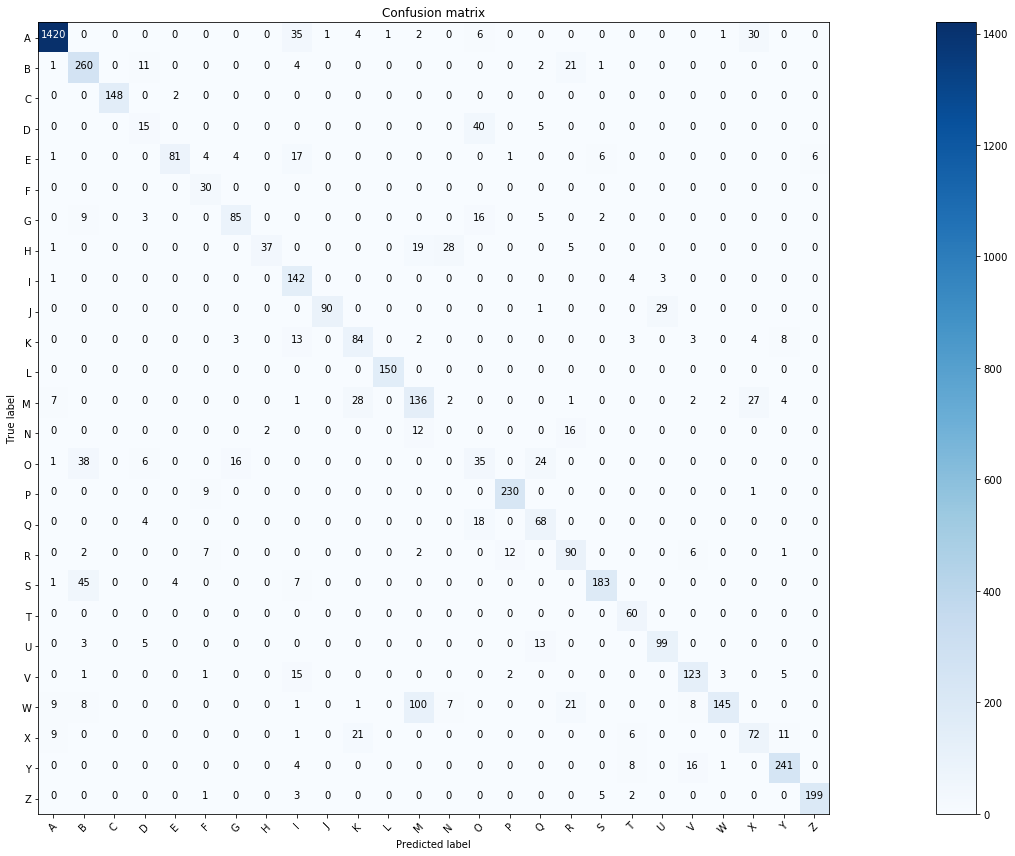

In [28]:
matriz = confusion_matrix(testlabel_caracteres, rpred_c)
plot_confusion_matrix(matriz, classes=[chr(i) for i in range(65, 65+26)])

In [29]:
accuracy_score(testlabel_caracteres, rpred_c)

0.8136801541425819

In [35]:
f1_score(testlabel_caracteres, rpred_c, average="macro")

0.7125652681966147

NotImplementedError: numpy() is only available when eager execution is enabled.

## CNN - MNIST Dataset

Nesta seção, o objetivo será comparar os resultados obtidos da cnn treinada anteriormente com a mesma rede neural, porém treinada com os dados do MNIST dataset, que possui dígitos manuscritos. Em seguida, tentaremos reconhecer os dígitos das placas com essa rede, e avaliar a sua capacidade de generalização.

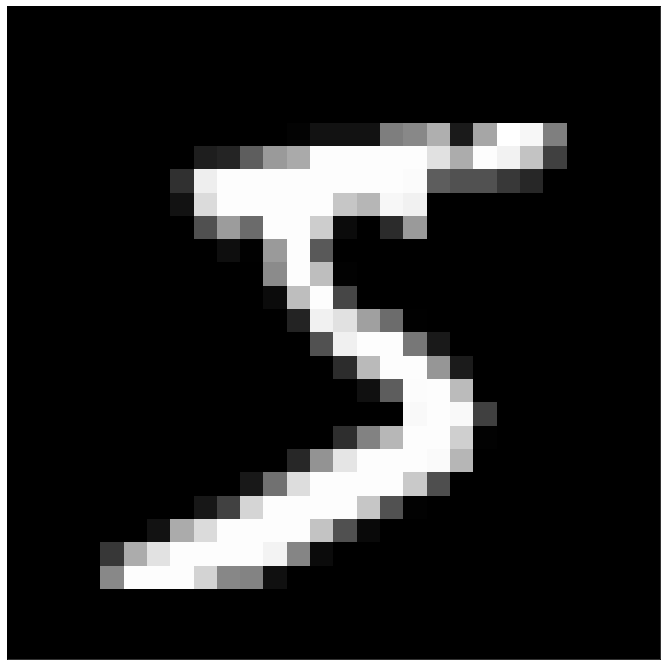

In [54]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
plot(x_train[0])

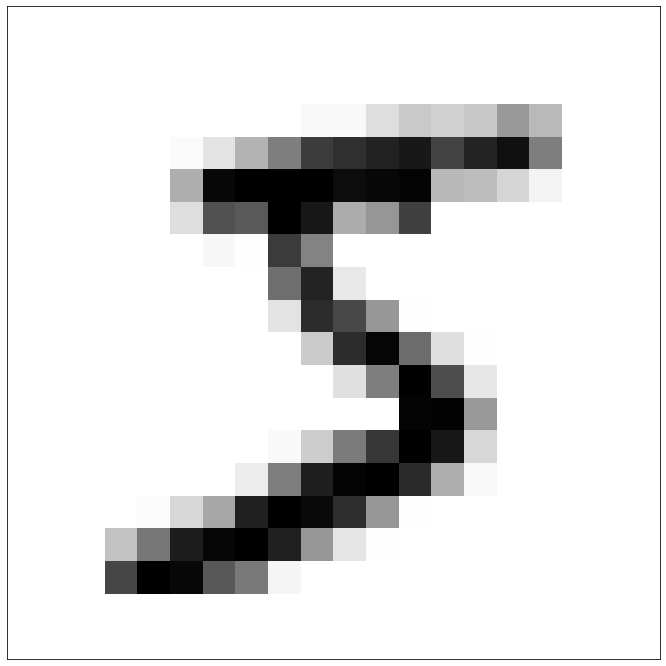

In [55]:
x_train = np.array([ cv2.bitwise_not(cv2.resize(img, (20, 20))) for img in x_train ])
x_test = np.array([ cv2.bitwise_not(cv2.resize(img, (20, 20))) for img in x_test ])

plot(x_train[0])

x_train = np.array([np.expand_dims(xti, axis=2) for xti in x_train])
x_test = np.array([np.expand_dims(xte, axis=2) for xte in x_test])

In [56]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [76]:
model_mnist = keras.models.clone_model(model)
model_mnist.compile(optimizer="adam",
              metrics=["categorical_accuracy"],
              loss="categorical_crossentropy")

In [77]:
mnist_categorico = to_categorical(y_train, num_classes=10)
model_mnist.fit(x_train, mnist_categorico, validation_split=prop_validacao_digitos, epochs=20, callbacks=[get_tboard(3)])

Train on 39936 samples, validate on 20064 samples
Epoch 1/20
39936/39936 [==============================] - 48s 1ms/sample - loss: 0.3352 - categorical_accuracy: 0.8907 - val_loss: 0.1229 - val_categorical_accuracy: 0.9614
Epoch 2/20
39936/39936 [==============================] - 49s 1ms/sample - loss: 0.0986 - categorical_accuracy: 0.9697 - val_loss: 0.1356 - val_categorical_accuracy: 0.9622
Epoch 3/20
39936/39936 [==============================] - 48s 1ms/sample - loss: 0.0693 - categorical_accuracy: 0.9791 - val_loss: 0.1110 - val_categorical_accuracy: 0.9683
Epoch 4/20
39936/39936 [==============================] - 49s 1ms/sample - loss: 0.0529 - categorical_accuracy: 0.9842 - val_loss: 0.0920 - val_categorical_accuracy: 0.9742
Epoch 5/20
39936/39936 [==============================] - 48s 1ms/sample - loss: 0.0403 - categorical_accuracy: 0.9882 - val_loss: 0.1165 - val_categorical_accuracy: 0.9719
Epoch 6/20
39936/39936 [==============================] - 47s 1ms/sample - loss: 0.03

In [78]:
mnist_pred = model_mnist.predict(x_test)
mnist_pred = [np.argmax(mn) for mn in mnist_pred]

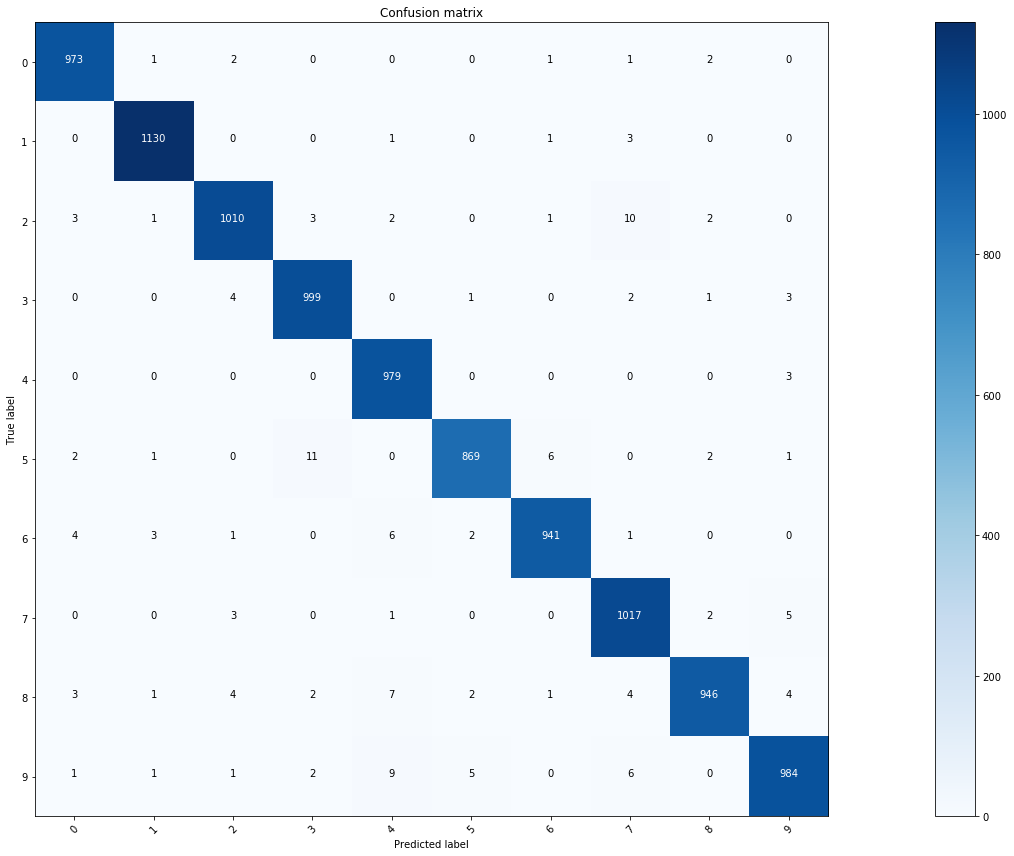

In [79]:
matriz_mnist = confusion_matrix(y_test, mnist_pred)
plot_confusion_matrix(matriz_mnist, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [80]:
accuracy_score(y_test, mnist_pred)

0.9848

In [81]:
mnist_pred_dig = model_mnist.predict(digitos)
mnist_pred_dig = [np.argmax(mpd) for mpd in mnist_pred_dig]

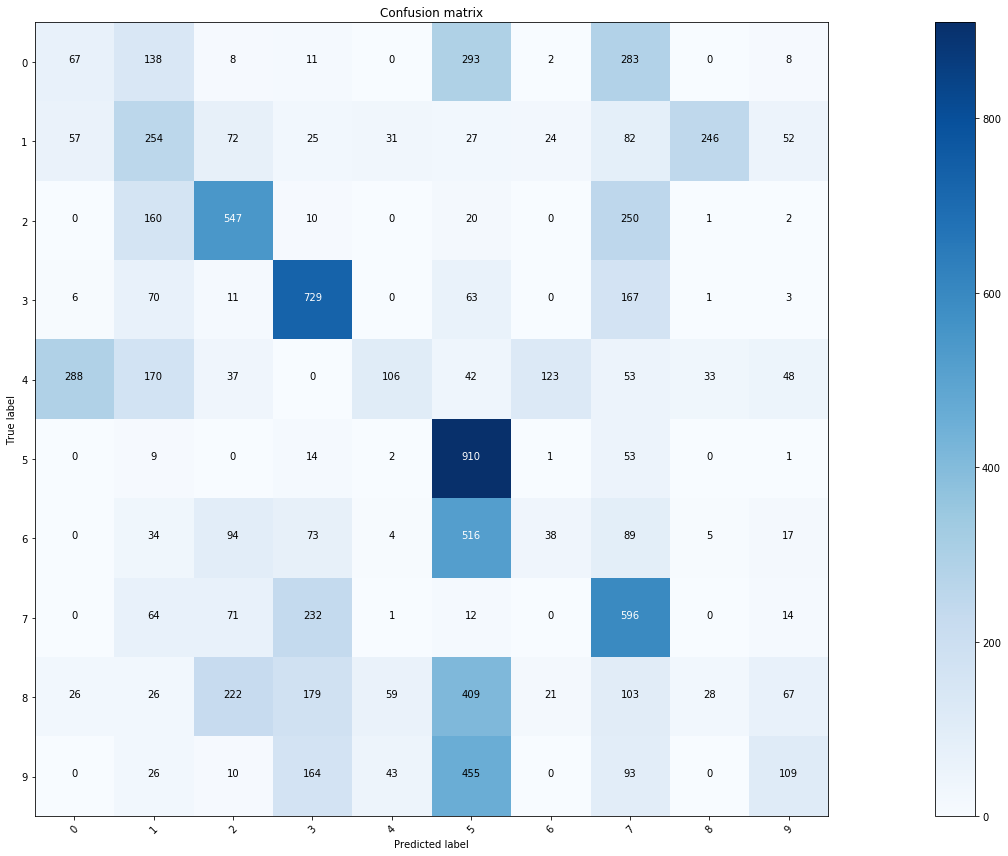

In [82]:
matriz_mnist_dig = confusion_matrix(label_digitos, mnist_pred_dig)
plot_confusion_matrix(matriz_mnist_dig, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [83]:
accuracy_score(label_digitos, mnist_pred_dig)

0.35583596214511043